In [1]:
import torch
from torch import nn, optim
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import pdb

%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

##Data generation

In [3]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([3., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p_data = 0.7 # prob of the first peak in data space
N = 10000 # amount of data
batch_size = 100
num_epoches = 750
z_dim = 2

In [4]:
c = torch.distributions.Bernoulli(p_data). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [5]:
X = c * a + (1 - c) * b
Y = torch.cat((X, c), 1)

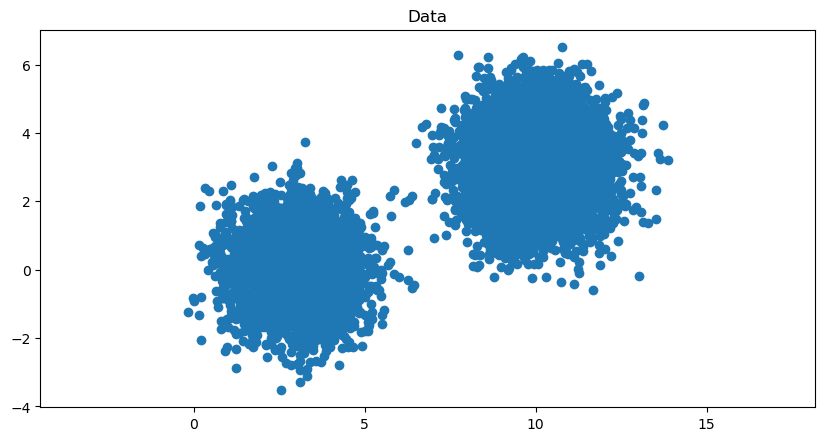

In [6]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Data')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [7]:
class VAE_MoG_prior(nn.Module):
    def __init__(self):
        super(VAE_MoG_prior, self).__init__()

        self.fc0 = nn.Linear(2, 5) # for encoder
        self.fc1 = nn.Linear(5, 10)
        self.fc2 = nn.Linear(10, z_dim) 
        self.fc3 = nn.Linear(10, z_dim)

        self.fc4 = nn.Linear(z_dim, 10) # for decoder
        self.fc5 = nn.Linear(10, 5)
        self.fc6 = nn.Linear(5, 2)
    
    def encode(self, x):
        h = torch.relu(self.fc0(x))
        g = torch.relu(self.fc1(h))
        return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar * 0.5)
        eps = torch.randn_like(std)
        return mu + eps * std
  
    def decode(self, z):
        h = torch.relu(self.fc4(z))
        g = torch.relu(self.fc5(h))
        return self.fc6(g) # mu_0 -- parameter of p_{theta}

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
model = VAE_MoG_prior().to(device)

In [9]:
p_prior = nn.Parameter(torch.tensor(0.5, device=device, dtype=torch.float32), requires_grad=False)

m_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
m_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

logvar_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
logvar_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

In [10]:
params = list(model.parameters()) + [p_prior, m_1, logvar_1, m_2, logvar_2]

In [11]:
optimizer = optim.Adam(params=params, lr=1e-3)

$L = KL - ELH = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - KL(q_{\phi}(z|x)||p(z))) = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - \mathbb{E}_{q_{\phi}(z|x)}(\log{q_{\phi}(z|x)} - \log{p(z)}))$

$\mathbb{E}_{q_{\phi}(z|x)}\log{q_{\phi}(z|x)} = \int q_{\phi}(z|x)\log{q_{\phi}(z|x)}dz = -\frac{J}{2}\log{2\pi} - \frac{1}{2}\sum_{j = 1}^{J}{(1+\log{\sigma_{j}^{2}})}$

In [12]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                        scale=torch.tensor(1., device=device, dtype=torch.float32))

In [13]:
def loss_function(x, mu_0, mu, logvar, p_prior, m_1, m_2, logvar_1, logvar_2): # mu_0 -- mean of p_{theta}; mu, logvar -- parameters of q_{phi}, p, m_1, m_2, logvar_1, logvar_2 -- parameters of prior p(z)
    g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp())
    g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp())
    z_0 = mu + std_normal.sample(mu.shape) * (logvar * 0.5).exp() # reparametrization
    A = -0.5 * (1 + logvar)
    concat_tensor = torch.cat([(torch.log(p_prior) + g_1.log_prob(z_0))[None], (torch.log(1. - p_prior) + g_2.log_prob(z_0))[None]], dim=0)
    B = torch.logsumexp(concat_tensor, dim=0) #  1-MC approximation of E_{q_{phi}}[log p(z)]
    KL = A - B
    p_theta = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
    ELH = p_theta.log_prob(x) # 1-MC approximation of expected log-likelihood
    return KL.mean() - ELH.mean()

In [14]:
dataloader = DataLoader(Y[:, 0:2], batch_size = batch_size, shuffle = True)

In [ ]:
for epoch in tqdm(range(num_epoches)):
    for batch in dataloader:
        mu_0, mu, logvar = model(batch)
        loss = loss_function(batch, mu_0, mu, logvar, p_prior, m_1, m_2, logvar_1, logvar_2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 50 == 0:
        print("loss =", loss.cpu().detach().numpy())

  0%|          | 1/750 [00:00<07:09,  1.74it/s]

loss = 27.729248


  7%|▋         | 51/750 [00:31<07:02,  1.66it/s]

loss = 4.1326694


 13%|█▎        | 101/750 [01:03<07:37,  1.42it/s]

loss = 3.9961584


 20%|██        | 151/750 [01:34<06:15,  1.60it/s]

loss = 3.9697883


 27%|██▋       | 201/750 [02:05<05:54,  1.55it/s]

loss = 3.9528995


 33%|███▎      | 251/750 [02:37<04:52,  1.71it/s]

loss = 4.030986


 40%|████      | 301/750 [03:06<04:18,  1.73it/s]

loss = 3.8990169


 47%|████▋     | 351/750 [03:35<03:53,  1.71it/s]

loss = 3.955195


 53%|█████▎    | 401/750 [04:04<03:23,  1.71it/s]

loss = 3.9479566


 60%|██████    | 451/750 [04:33<02:51,  1.74it/s]

loss = 3.9586902


 67%|██████▋   | 501/750 [05:02<02:25,  1.71it/s]

loss = 3.9573407


 73%|███████▎  | 551/750 [05:31<01:56,  1.71it/s]

loss = 3.8758159


 80%|████████  | 601/750 [06:00<01:26,  1.72it/s]

loss = 3.900013


 87%|████████▋ | 651/750 [06:29<00:57,  1.73it/s]

loss = 3.9762993


 93%|█████████▎| 701/750 [06:58<00:28,  1.74it/s]

loss = 4.001914


 95%|█████████▌| 715/750 [07:06<00:20,  1.70it/s]

##Generation

In [ ]:
bern = torch.distributions.Bernoulli(p_prior).sample((1000, )).view(-1, 1)
g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp()).sample((1000, ))
g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp()).sample((1000, ))

pr_samples = bern * g_1 + (1 - bern) * g_2 # get 1000 samples from trained prior

In [ ]:
mu_post = model.decode(pr_samples).detach() # means of p_{theta}(x|z)

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(mu_post[:, 0].cpu(), mu_post[:, 1].cpu(), label='Generated data')
plt.axis('equal')
plt.legend();

##Prior visualization

In [ ]:
print("Prior parameters:")
print("p_prior = ", p_prior.cpu().numpy())
print("m_1 =", m_1.detach().cpu().numpy(), "logvar_1 =", logvar_1.detach().cpu().numpy())
print("m_2 =", m_2.detach().cpu().numpy(), "logvar_2 =", logvar_2.detach().cpu().numpy())

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples from prior')
plt.scatter(pr_samples[:, 0].cpu(), pr_samples[:, 1].cpu())
plt.axis('equal')
plt.legend();

##Reconstruction

In [ ]:
X_rec = model(X) # reconstructed data

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(X_rec[0][:, 0].detach().cpu(), X_rec[0][:, 1].detach().cpu(), label='Reconstructed data')
plt.axis('equal')
plt.legend();

##Latent space vizualization

In [ ]:
mu1_q, logvar1_q = model.encode(Y[Y[:, 2] == 0, 0:2])
mu2_q, logvar2_q = model.encode(Y[Y[:, 2] == 1, 0:2])

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu_q - mean of q_{phi} distr')
plt.scatter(mu1_q[:, 0].detach().cpu(), mu1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(mu2_q[:, 0].detach().cpu(), mu2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();

In [ ]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar_q - log variance of q_{phi} distr')
plt.scatter(logvar1_q[:, 0].detach().cpu(), logvar1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(logvar2_q[:, 0].detach().cpu(), logvar2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();

## Estimation of $\log{p_{\theta}(X)}$

In [ ]:
# To ensure we are using the same dataset for evaluation

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
n_IS = 10000
N_test = 5000

In [ ]:
c_test = torch.distributions.Bernoulli(p_data). sample((N_test, )).to(device).view(-1, 1)
a_test = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N_test, ))
b_test = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N_test, ))

X_test = c_test * a_test + (1 - c_test) * b_test

In [ ]:
def prior_log_prob(z, p_prior, m_1, logvar_1, m_2, logvar_2): # returns log p_{lambda}(z) for MoG prior
    g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp())
    g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp())
    concat_tensor = torch.cat([(torch.log(p_prior) + g_1.log_prob(z))[None], (torch.log(1. - p_prior) + g_2.log_prob(z))[None]], dim=0)
    return torch.logsumexp(concat_tensor, dim=0).sum(1)

In [ ]:
test_batch_size = 10
test_dataloader = DataLoader(X_test, batch_size=test_batch_size, shuffle=False, )

In [ ]:
batch_mean = []
j = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.repeat(n_IS, 1)
        mu_q, logvar_q = model.encode(batch)
        
        eps = std_normal.sample(mu_q.shape)
        z = mu_q + eps * torch.exp(logvar_q * 0.5)
        m_0 = model.decode(z) # means of p_theta
        
        log_p_theta = torch.distributions.MultivariateNormal(loc=m_0, covariance_matrix=covar).log_prob(m_0)
        log_q = std_normal.log_prob(eps).sum(1)
        log_prior = prior_log_prob(z, p_prior, m_1, logvar_1, m_2, logvar_2)
        
        ll_raw = (log_p_theta + log_prior - log_q).view(*[n_IS, -1])
        
        ll_lse = torch.logsumexp(ll_raw, dim=0)
        ll = -np.log(n_IS) + torch.mean(ll_lse)
        batch_mean.append(torch.mean(ll).cpu().detach().numpy())

In [ ]:
print("mean =", np.mean(batch_mean)) # mean of log p_{theta}(x)
print("std =", np.std(batch_mean))